<a href="https://colab.research.google.com/github/maaz1m/deep-convolutional-generative-adversarial-network/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Convolutional Generative Adversarial Networks

A DCGAN is simply a GAN that uses a convolutional neural network as the discriminator, and
a network composed of transposed convolutions as the generator. To implement the DCGAN, we
need to specify three things: 1) the generator, 2) the discriminator, and 3) the training procedure.


In [ ]:
# Uncomment and run these in Colab
%tensorflow_version 1.x
!pip install --upgrade opencv-python==3.4.2.17
import numpy as np
import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Conv2D,Activation,BatchNormalization,Conv2DTranspose, Input, Flatten, Dense, Reshape, LeakyReLU, Dropout
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
import os
from glob import glob
from skimage.io import imread,imshow,imsave
from skimage.transform import resize
import matplotlib.pyplot as plt
import cv2
import math
from keras.preprocessing import image as k_image
from keras.utils.generic_utils import Progbar
from keras.initializers import RandomNormal
import random

TensorFlow 1.x selected.
     |████████████████████████████████| 25.0MB 41.2MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
ROLLNUMBER = 20100068
BATCH_SIZE = 128
IMAGE_SHAPE = [64,64]
CHANNELS = 3
INPUT_SHAPE = (64,64,3)
NOISE_DIM = 100
EPOCHS = 1200
# Use this to prefix all your paths when reading/writing data to drive.
BASE_DIR = '/content/drive/My Drive/LUMS/CS437'

- Here's the link to the emojis dataset: https://drive.google.com/open?id=1WRpE9SwSqguyGrrI9EP6jlHk7f1hoJMo

- Here's the link to the full emojis dataset: https://drive.google.com/open?id=1UeIQIbixvapM-TBzngOwDXnHV_vv-MBG

In [ ]:
## Helper Functions
def sample_noise():
    return np.reshape(np.random.randn(NOISE_DIM * BATCH_SIZE),(BATCH_SIZE,NOISE_DIM))

def remove_transparency(source, background_color):
    source_img = source[:, :, :3]
    source_mask = source[:, :, 3]  * (1 / 255.0)
    source_mask = np.repeat(source_mask[:, :, np.newaxis], 3, axis=2)
    background_mask = 1.0 - source_mask
    bg_part = (background_color * (1 / 255.0)) * (background_mask)
    source_part = (source_img * (1 / 255.0)) * (source_mask)
    return cv2.cvtColor(np.uint8(cv2.addWeighted(bg_part, 255.0, source_part, 255.0, 0.0)),cv2.COLOR_BGR2RGB)

def load_data(directory):
    train_files = glob(directory+'/*')
    train_images = np.array([cv2.resize(remove_transparency(cv2.imread(f,-1),255),tuple(IMAGE_SHAPE)) for f in train_files])
    print('Loaded ' + str(len(train_files))+ ' images to memory')
    return train_images

def create_image_grid(array, ncols=None):
    num_images, cell_h, cell_w, channels = array.shape
    if not ncols:
        ncols = int(np.sqrt(num_images))
    nrows = int(np.math.floor(num_images / float(ncols)))
    result = np.zeros((cell_h*nrows, cell_w*ncols, channels), dtype=array.dtype)
    for i in range(0, nrows):
        for j in range(0, ncols):
            result[i*cell_h:(i+1)*cell_h, j*cell_w:(j+1)*cell_w, :] = array[i*ncols+j]

    if channels == 1:
        result = result.squeeze()
    return result

### 1 Discriminator


In [ ]:
def build_discriminator():
    inp = Input(shape=INPUT_SHAPE)
    conv1 = Conv2D(filters = 64, kernel_size= (4,4), padding = 'same', strides = (2,2), use_bias = False)(inp)
    bnorm1 = BatchNormalization()(conv1)
    lrelu1 = LeakyReLU()(conv1)
    conv2 = Conv2D(filters = 128, kernel_size= (4,4), padding = 'same', strides = (2,2), use_bias = False)(lrelu1)
    bnorm2 = BatchNormalization()(conv2)
    lrelu2 = LeakyReLU()(bnorm2)
    conv3 = Conv2D(filters = 256, kernel_size= (4,4), padding = 'same', strides = (2,2), use_bias = False)(lrelu2)
    bnorm3 = BatchNormalization()(conv3)
    lrelu3 = LeakyReLU()(bnorm3)
    conv4 = Conv2D(filters = 512, kernel_size= (4,4), padding = 'same', strides = (2,2), use_bias = False)(lrelu3)
    bnorm4 = BatchNormalization()(conv4)
    lrelu4 = LeakyReLU()(bnorm4)
    conv5 = Conv2D(filters = 1, kernel_size = (2,2), padding = 'same', use_bias = False)(lrelu4)
    bnorm5 = BatchNormalization()(conv4)
    lrelu5 = LeakyReLU()(bnorm5)
    flatten = Flatten()(lrelu5)
    dense = Dense(units = 1, activation='sigmoid')(flatten)
    model =  Model(inputs=inp, outputs=dense, name = 'discriminator')
    model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

### Generator

In [ ]:
def build_generator():
    input1 = Input(shape=(NOISE_DIM,))
    dense1 = Dense(4*4*1024, activation='relu')(input1)    
    reshape1 = Reshape((4, 4, 1024))(dense1)
    conv1 = Conv2DTranspose(512, kernel_size=(5,5), strides = (2,2), activation='relu', padding='same', use_bias=False)(reshape1)
    conv2 = Conv2DTranspose(256, kernel_size=(5,5), strides = (2,2), activation='relu', padding='same', use_bias=False)(conv1)
    conv3 = Conv2DTranspose(128, kernel_size=(5,5), strides = (2,2), activation='relu', padding='same', use_bias=False)(conv2)
    conv4 = Conv2DTranspose(3, kernel_size=(5,5), strides = (2,2), activation='tanh', padding='same', use_bias=False)(conv3)
    model = Model(inputs=input1, outputs=conv4, name='generator')
    model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy')

    return model

### 3 DCGAN Training Loop

In [ ]:
def build_gan(gen,disc):
    gan = Sequential([
        gen,
        disc
    ])
    return gan

In [ ]:
def plot_loss(gen_loss,disc_loss):
    plt.plot(gen_loss)
    plt.plot(disc_loss)
    plt.title('GAN Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Generator', 'Discriminator'], loc='upper left')
    plt.show()

In [ ]:
def save_samples(generated_images,step,save_at="samples/"):
    sample_image = create_image_grid(generated_images)
    img = k_image.array_to_img(sample_image)
    img.save(os.path.join(BASE_DIR,save_at, 'generated_image_' + str(step) + '.png'))

def show_samples(generated_imgs):
    plt.figure(figsize=(8, 6))
    for i in range(12):
        img = generated_imgs[i]
        plt.subplot(3, 4, i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

def modify_trainability(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

In [ ]:
def gan_training_loop(X_train, intervals=200):
    generator = build_generator()
    discriminator = build_discriminator()    
    gan = build_gan(generator, discriminator)

    total_size = X_train.shape[0]
    indices = np.arange(0,total_size ,BATCH_SIZE)
    all_disc_loss = []
    all_gen_loss = []
    if total_size % BATCH_SIZE:
        indices = indices[:-1]
    for e in range(EPOCHS):
        progress_bar = Progbar(target=len(indices))
        np.random.shuffle(indices)
        epoch_gen_loss = []
        epoch_disc_loss = []
        for i,index in enumerate(indices):
            batch_start = index
            batch_end = index + BATCH_SIZE
            
            # draw m training examples
            X_batch_real = X_train[batch_start:batch_end]

            # draw m noise samples
            latent_samples = sample_noise()

            # generate fake images from the noise
            X_batch_fake = generator.predict_on_batch(latent_samples)

            # train discriminator and compute loss on real images and fake image batches
            disc_loss = discriminator.train_on_batch(X_batch_real, np.ones([BATCH_SIZE,1]))
            disc_loss += discriminator.train_on_batch(X_batch_fake, np.zeros([BATCH_SIZE,1]))            
            epoch_disc_loss.append(disc_loss)
            
            # draw m NEW noise samples
            latent_samples = sample_noise()

            # freeze discriminator
            modify_trainability(discriminator, False)

            # train generator and compute loss
            gen_loss = gan.train_on_batch(latent_samples, np.ones([BATCH_SIZE,1]))
            epoch_gen_loss.append(gen_loss)

            # unfreeze discriminator
            modify_trainability(discriminator, True)

            progress_bar.update(i+1)
        if not (e%intervals):
            discriminator.save_weights(os.path.join(BASE_DIR,'discriminator.h5'),True)
            generator.save_weights(os.path.join(BASE_DIR,'generator.h5'),True)
            
        avg_epoch_disc_loss = np.array(epoch_disc_loss).mean()
        avg_epoch_gen_loss = np.array(epoch_gen_loss).mean()
        all_disc_loss.append(avg_epoch_disc_loss)
        all_gen_loss.append(avg_epoch_gen_loss)

        print("Epoch: %d | Discriminator Loss: %f | Generator Loss: %f" % (e+1,avg_epoch_disc_loss,avg_epoch_gen_loss))
    return all_disc_loss,all_gen_loss

In [ ]:
X_train = load_data(BASE_DIR+'/filtered_emojis')

Loaded 725 images to memory


In [ ]:
disc_loss, gen_loss = gan_training_loop(X_train)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
5/5 [==============================] - 6s 1s/step
Epoch: 1 | Discriminator Loss: 0.495274 | Generator Loss: 0.415111
5/5 [==============================] - 2s 391ms/step
Epoch: 2 | Discriminator Loss: 0.200622 | Generator Loss: 1.165315
5/5 [==============================] - 2s 378ms/step
Epoch: 3 | Discriminator Loss: 0.163000 | Generator Loss: 1.365284
5/5 [==============================] - 2s 383ms/step
Epoch: 4 | Discriminator Loss: 0.137785 | Generator Loss: 1.564597
5/5 [==============================] - 2s 385ms/step
Epoch: 5 | Discriminator Loss: 0.126987 | Generator Loss: 1.653074
5/5 [==============================] - 2s 384ms/step
Epoch: 6 | Discriminator Loss: 0.127542 | Generator Loss: 1.667194
5/5 [==============================] - 2s 389ms/step
Epoch: 7 | Discriminator Loss: 0.124017 | Generator Loss: 1.785911
5/5 [==============================] - 2s 386ms/step
Epoch: 8 | Discr

### 4 Generating Samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

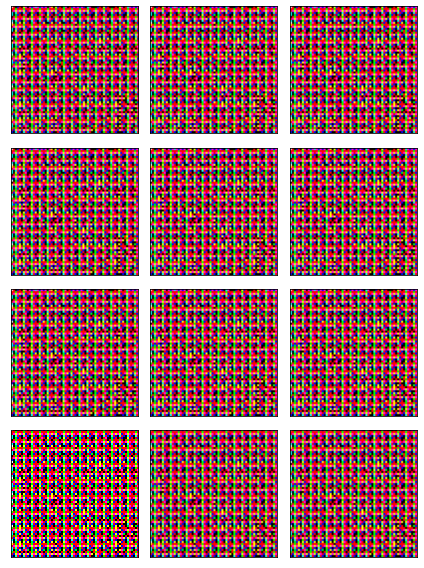

In [ ]:
generator = build_generator()
generator.load_weights(os.path.join(BASE_DIR,'generator.h5'))
latent_samples = sample_noise()
generated_imgs = generator.predict_on_batch(latent_samples)
show_samples(generated_imgs)


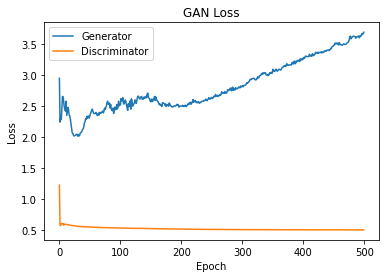

In [ ]:
plot_loss(gen_loss, disc_loss)

#### Analysis



*   No normalization, generator output is [-1,1] due to tanh however training images are all [0,255]
*   Model has encountered a failure mode, whereby the generator fails to decrease its loss since the discriminator has learnt too fast.
* Results are unsatisfactory



## 5 Stablizing GANs

### Modifications in the Models

Here are some modifications in the generator and discriminator models:

- Using LeakyReLu in BOTH the generator and discriminator
- Using Gaussian Weight initialization with mean=0 and std = 0.02
- Using Adam optimizer

In [ ]:
kern_init = RandomNormal(mean=0.0, stddev=0.02)

In [ ]:
def build_discriminator():
    inp = Input(shape=INPUT_SHAPE)
    conv1 = Conv2D(filters = 64, kernel_size= (4,4), padding = 'same', strides = (2,2), use_bias = False, kernel_initializer=kern_init)(inp)
    bnorm1 = BatchNormalization()(conv1)
    lrelu1 = LeakyReLU(0.2)(bnorm1)
    conv2 = Conv2D(filters = 128, kernel_size= (4,4), padding = 'same', strides = (2,2), use_bias = False, kernel_initializer=kern_init)(lrelu1)
    bnorm2 = BatchNormalization()(conv2)
    lrelu2 = LeakyReLU(0.2)(bnorm2)
    conv3 = Conv2D(filters = 256, kernel_size= (4,4), padding = 'same', strides = (2,2), use_bias = False, kernel_initializer=kern_init)(lrelu2)
    bnorm3 = BatchNormalization()(conv3)
    lrelu3 = LeakyReLU(0.2)(bnorm3)
    conv4 = Conv2D(filters = 512, kernel_size= (4,4), padding = 'same', strides = (2,2), use_bias = False, kernel_initializer=kern_init)(lrelu3)
    bnorm4 = BatchNormalization()(conv4)
    lrelu4 = LeakyReLU(0.2)(bnorm4)
    conv5 = Conv2D(filters = 1, kernel_size = (4,4), padding = 'same', use_bias = False, kernel_initializer=kern_init)(lrelu4)
    flatten = Flatten()(conv5)
    dense = Dense(units = 1, activation='sigmoid')(flatten)
    model =  Model(inputs=inp, outputs=dense, name = 'discriminator')
    return model

In [ ]:
def build_generator():
    inp = Input(shape=(NOISE_DIM,))
    dense = Dense(4*4*1024, activation='relu')(inp)    
    reshape = Reshape((4, 4, 1024))(dense)
    conv1 = Conv2DTranspose(512, kernel_size=(4,4), strides = (2,2), padding='same', use_bias=False, kernel_initializer=kern_init)(reshape)
    lrelu1 = LeakyReLU()(conv1)
    conv2 = Conv2DTranspose(256, kernel_size=(4,4), strides = (2,2), padding='same', use_bias=False, kernel_initializer=kern_init)(lrelu1)
    lrelu2 = LeakyReLU()(conv2)
    conv3 = Conv2DTranspose(128, kernel_size=(4,4), strides = (2,2), padding='same', use_bias=False, kernel_initializer=kern_init)(lrelu2)
    lrelu3 = LeakyReLU()(conv3)
    conv4 = Conv2DTranspose(3, kernel_size=(4,4), strides = (2,2), activation='tanh', padding='same', use_bias=False, kernel_initializer=kern_init)(lrelu3)
    model = Model(inputs=inp, outputs=conv4, name='generator')
    return model

### Scale Images to the Range [-1,1]

In [ ]:
def normalize(images):
    x = np.float64(images)
    x = (x / 255 - 0.5) * 2
    x = np.clip(x, -1, 1)
    print('Normalized ' + str(len(x))+ ' images')
    return x

def restore(x):
    images = ((x + 1) / 2) * 255
    images = np.clip(images, 0, 255)
    images = np.uint8(images)
    return images

### Use Gaussian Latent Space

In [ ]:
def sample_noise():
    return np.reshape(np.random.normal(0, 1, NOISE_DIM * BATCH_SIZE),(BATCH_SIZE,NOISE_DIM))

### Use Label Smoothing

In [ ]:
def smooth_real_labels():
    return np.reshape(np.random.uniform(0.7, 1.2, BATCH_SIZE*1), [BATCH_SIZE,1])
    

In [ ]:
def smooth_fake_labels():
    return np.reshape(np.random.uniform(-0.2, 0.3, BATCH_SIZE*1), [BATCH_SIZE,1])


### Modified Training Loop

Now we will train our discriminator in two updates, one for the real images and one for the fake images. Moreover, we will also be flipping the labels of the generator.

In [ ]:
def gan_training_loop(X_train, intervals=200, lr=0.00005):

    generator = build_generator()

    discriminator = build_discriminator()    
    discriminator.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
    modify_trainability(discriminator, False)

    gan = build_gan(generator, discriminator)
    gan.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

    total_size = X_train.shape[0]
    indices = np.arange(0,total_size ,BATCH_SIZE)
    all_disc_loss = []
    all_gen_loss = []
    if total_size % BATCH_SIZE:
        indices = indices[:-1]
    for e in range(EPOCHS):
        progress_bar = Progbar(target=len(indices))
        np.random.shuffle(indices)
        epoch_gen_loss = []
        epoch_disc_loss = []
        for i,index in enumerate(indices):
            batch_start = index
            batch_end = index + BATCH_SIZE
            
            # draw m training examples
            X_batch_real = X_train[batch_start:batch_end]

            # draw m noise samples
            latent_samples = sample_noise()

            # generate fake images from the noise
            X_batch_fake = generator.predict_on_batch(latent_samples)

            # unfreeze discriminator
            modify_trainability(discriminator, True)

            # train discriminator and return loss on real images and fake image batches
            disc_loss = discriminator.train_on_batch(X_batch_real, smooth_real_labels())
            disc_loss += discriminator.train_on_batch(X_batch_fake, smooth_fake_labels())            
            epoch_disc_loss.append(disc_loss)
            
            # freeze discriminator
            modify_trainability(discriminator, False)

            # draw m NEW noise samples
            latent_samples = sample_noise()


            # train generator and return loss
            gen_loss = gan.train_on_batch(latent_samples, smooth_real_labels())
            epoch_gen_loss.append(gen_loss)

            progress_bar.update(i+1)
        if not (e%intervals):
            discriminator.save_weights(os.path.join(BASE_DIR,'weights/discriminator.h5'),True)
            generator.save_weights(os.path.join(BASE_DIR,'weights/generator.h5'),True)
            save_samples(X_batch_fake, e)
            
        avg_epoch_disc_loss = np.array(epoch_disc_loss).mean()
        avg_epoch_gen_loss = np.array(epoch_gen_loss).mean()
        all_disc_loss.append(avg_epoch_disc_loss)
        all_gen_loss.append(avg_epoch_gen_loss)

        print("Epoch: %d | Discriminator Loss: %f | Generator Loss: %f" % (e+1,avg_epoch_disc_loss,avg_epoch_gen_loss))
    return all_disc_loss,all_gen_loss

In [ ]:
X_train = load_data(BASE_DIR+'/filtered_emojis')
X_train_norm = normalize(X_train)

Loaded 725 images to memory
Normalized 725 images


In [ ]:
disc_loss, gen_loss = gan_training_loop(X_train_norm)

5/5 [==============================] - 10s 2s/step
Epoch: 1 | Discriminator Loss: 0.607806 | Generator Loss: 0.378995
5/5 [==============================] - 4s 817ms/step
Epoch: 2 | Discriminator Loss: 0.245298 | Generator Loss: 1.139664
5/5 [==============================] - 4s 825ms/step
Epoch: 3 | Discriminator Loss: 0.219902 | Generator Loss: 1.273900
5/5 [==============================] - 4s 819ms/step
Epoch: 4 | Discriminator Loss: 0.172650 | Generator Loss: 1.680351
5/5 [==============================] - 4s 820ms/step
Epoch: 5 | Discriminator Loss: 0.118375 | Generator Loss: 1.792011
5/5 [==============================] - 4s 820ms/step
Epoch: 6 | Discriminator Loss: 0.131549 | Generator Loss: 1.953550
5/5 [==============================] - 4s 820ms/step
Epoch: 7 | Discriminator Loss: 0.131485 | Generator Loss: 2.042189
5/5 [==============================] - 4s 820ms/step
Epoch: 8 | Discriminator Loss: 0.108155 | Generator Loss: 2.095643
5/5 [==============================] - 4s 

### Analysis 
Repeat the above analysis and mention changes you observed in terms of training and quality of fake images

#### Results

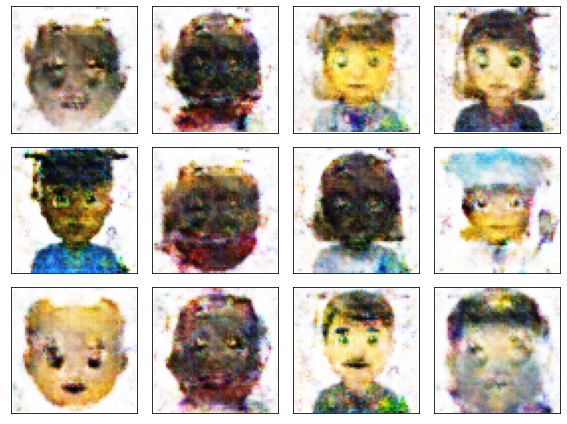

In [ ]:
generator = build_generator()
generator.load_weights(os.path.join(BASE_DIR,'weights/generator.h5'))
latent_samples = sample_noise()
predictions = generator.predict_on_batch(latent_samples)
generated_imgs = restore(predictions) 
show_samples(generated_imgs)